In [1]:
import os
import imageio
import cv2
import numpy as np
import h5py
import csv
import os
from config import PARAS
SR, N_FFT, N_MEL = PARAS.SR, PARAS.N_FFT, PARAS.N_MEL
import librosa
from IPython.display import Audio

import soundfile as sf
#test_dict = 'test_dict.h5py'
file_path = '../data'
video_path = '../data/test/akwvpAiLFk0_144.680000-150.000000.mp4'
outfile_path = 'test_dict.csv'
fnames = ['address', 'count', 'video_name', 'time']

In [2]:
SR

16000

In [3]:
def build_dict(infile_path, outfile_path):
    with open(outfile_path, 'w',newline='') as f:
        writer = csv.DictWriter(f,fieldnames = fnames)
        
        count = 0
        path_dict = dict()
        for (dirpath, dirnames, filenames) in os.walk(infile_path):
            dirpath = dirpath.replace('\\','/')
            if not dirnames:
                if 'test' in dirpath:
                    for filename in filenames:
                        path = dirpath + '/' + filename
                        video, time = filename.split('_')[0], filename.split('_')[1].strip('.mp4')
                        path_dict[path] = (count, video, time)
                        count += 1
                        row = [path, int(count), video, time]
                        writer.writerow({'address': path,'count': count, 'video_name': video,'time':time})
        
                    
    #return path_dict

In [4]:
def frames():
    pass

def audio():
    pass

mix_path = '../mixture_data/audio'
audio_path = '../separated_data/audio'
def audio_merge(audio_path, mix_path):
    f = []
    for (dirpath, dirnames, filenames) in os.walk(audio_path):
        f.extend(filenames)
        break

    for i in range(len(f)):
        path1 = f[i]
        name1 = path1.split('.')[0]
        path2_count = i + 1
        if path2_count == len(f):
            break
        while filenames[path2_count].split('-')[0] not in path1:
            path2 = f[path2_count]
            name2 = path2.split('.')[0]
            
            ### load
            signal1, _ = librosa.load(audio_path + '/' + path1, sr=SR)
            signal2, _ = librosa.load(audio_path + '/' + path2, sr=SR)
            ### 3.2s
            signal1_slice = signal1[:3*SR]
            signal2_slice = signal2[:3*SR]
            ### normalize
            signal1_n2 = librosa.util.normalize(signal1_slice, norm=2)
            signal2_n2 = librosa.util.normalize(signal2_slice, norm=2)
            ### merge
            signal3 = signal1_n2 + signal2_n2
            ### write mix_wav
            try:
                os.makedirs(mix_path)
            except FileExistsError:
                pass
            name3 = name1 + '~' + name2 + '.wav'
            dir3 = mix_path + '/' + name3
            sf.write(dir3, signal3, samplerate=SR)
#             ### feature extraction
#             signal3_mel = librosa.feature.melspectrogram(y=signal3, sr=SR, n_mels=N_MEL)
#             signal1_mel = librosa.feature.melspectrogram(y=signal1, sr=SR, n_mels=N_MEL)
#             signal2_mel = librosa.feature.melspectrogram(y=signal2, sr=SR, n_mels=N_MEL)
#             ### save h5py
            path2_count += 1
            if path2_count == len(f):
                break
          

In [5]:
PARAS.SR

16000

In [6]:
import numpy as np
import librosa
from config import PARAS
from IPython.display import Audio


class MelConverter:

    def __init__(self, sample_rate=PARAS.SR,
                 n_fft=PARAS.N_FFT,
                 #hop_length=PARAS.N_FFT // 4,
                 hop_length=160,
                 n_mel_freqs=PARAS.N_MEL,
                 freq_min_hz=0, freq_max_hz=None):

        self._SAMPLE_RATE = sample_rate
        self._N_FFT = n_fft
        self._HOP_LENGTH = hop_length
        self._N_MEL_FREQS = n_mel_freqs
        self._FREQ_MIN_HZ = freq_min_hz
        self._FREQ_MAX_HZ = freq_max_hz

        self._MEL_FILTER = librosa.filters.mel(
            sr=self._SAMPLE_RATE,
            n_fft=self._N_FFT,
            n_mels=self._N_MEL_FREQS,
            fmin=self._FREQ_MIN_HZ,
            fmax=self._FREQ_MAX_HZ)

    def signal_to_melspec(self, audio_signal, log=True, get_phase=False, transpose=False):
        D = librosa.core.stft(audio_signal, n_fft=self._N_FFT, hop_length=self._HOP_LENGTH)
        magnitude, phase = librosa.core.magphase(D)
        mel_spectrogram = np.dot(self._MEL_FILTER, magnitude)
        mel_spectrogram = mel_spectrogram ** 2

        if log:
            mel_spectrogram = librosa.power_to_db(mel_spectrogram)
        if transpose:
            mel_spectrogram = mel_spectrogram.T
        if get_phase:
            return mel_spectrogram, phase
        else:
            return mel_spectrogram

    def melspec_to_audio(self, mel_spectrogram, log=True, phase=None, transpose=False, audio_out=True):
        if transpose:
            mel_spectrogram = mel_spectrogram.T
        if log:
            mel_spectrogram = librosa.db_to_power(mel_spectrogram)

        mel_spectrogram = mel_spectrogram ** 0.5

        magnitude = np.dot(np.linalg.pinv(self._MEL_FILTER), mel_spectrogram)

        if phase is not None:
            inverted_signal = librosa.istft(magnitude * phase, hop_length=self._HOP_LENGTH)
        else:
            inverted_signal = griffin_lim(magnitude, self._N_FFT, self._HOP_LENGTH, n_iterations=10)

        if audio_out:
            return Audio(inverted_signal, rate=self._SAMPLE_RATE)
        else:
            return inverted_signal


def griffin_lim(magnitude, n_fft, hop_length, n_iterations):
    """Iterative algorithm for phase retrival from a magnitude spectrogram."""
    phase_angle = np.pi * np.random.rand(*magnitude.shape)
    D = invert_magnitude_phase(magnitude, phase_angle)
    signal = librosa.istft(D, hop_length=hop_length)

    for i in range(n_iterations):
        D = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
        _, phase = librosa.magphase(D)
        phase_angle = np.angle(phase)

        D = invert_magnitude_phase(magnitude, phase_angle)
        signal = librosa.istft(D, hop_length=hop_length)

    return signal


def invert_magnitude_phase(magnitude, phase_angle):
    phase = np.cos(phase_angle) + 1.j * np.sin(phase_angle)
    return magnitude * phase

In [7]:
l1 = '../separated_data/audio/CJoOwXcjhds-233.266000-239.367000.wav'
signal1, _ = librosa.load(l1, sr=SR)
signal1[:3*SR].shape

(48000,)

In [8]:
converter = MelConverter()
mel, phase = converter.signal_to_melspec(signal1[:3*SR], get_phase=True)
mel.shape

(150, 301)

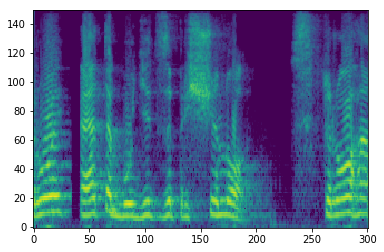

In [10]:
import matplotlib.pyplot as plt
plt.imshow(mel,aspect='auto', origin='lower')

In [11]:
restore_signal1 = converter.melspec_to_audio(mel, audio_out=False)
restore_signal1.shape

(48000,)

In [12]:
Audio(restore_signal1, rate=SR)

In [10]:
#audio_merge(audio_path, mix_path)

In [166]:
def mel_extractor(mix_path, separated_path):
    converter = MelConverter()
    f = []
    for (dirpath, dirnames, filenames) in os.walk(mix_path):
        f.extend(filenames)
        break
    
    for i in range(len(f)):
        signal, _ = librosa.load(mix_path + '/' + f[i], sr=SR)
        mel = converter.signal_to_melspec(signal)
        
    
    

In [20]:
signal3_mel = librosa.feature.melspectrogram(y=s3, sr=SR, n_mels=N_MEL)
signal2_mel = librosa.feature.melspectrogram(y=signal2[:int(3*16000)], sr=SR, n_mels=N_MEL)
signal1_mel = librosa.feature.melspectrogram(y=signal1[:int(3*16000)], sr=SR, n_mels=N_MEL)

In [21]:
signal3_mel

array([[3.03955253e+00, 1.02584233e+00, 1.60631192e+00, ...,
        6.56113975e-01, 4.47272967e-02, 2.82002286e-01],
       [1.54266684e+00, 4.53134057e-01, 2.12949247e-01, ...,
        3.11112207e-01, 8.91035182e-02, 2.94277402e-01],
       [3.17036571e+00, 8.64634015e-01, 1.04077710e-01, ...,
        5.26306375e-01, 1.51479943e-01, 4.09614338e-01],
       ...,
       [1.38720767e-02, 3.47141882e-03, 5.58138489e-05, ...,
        3.49327532e-03, 5.38960353e-03, 3.13536228e-03],
       [1.45253487e-02, 3.63174533e-03, 8.15816180e-06, ...,
        6.34619882e-04, 7.55162107e-04, 9.44892615e-04],
       [1.36425351e-02, 3.41068370e-03, 5.04459024e-07, ...,
        1.36332301e-05, 3.65632997e-05, 4.56300039e-04]])

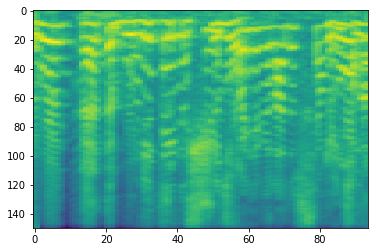

In [22]:
import matplotlib.pyplot as plt
plt.imshow(np.log(signal3_mel),aspect='auto')

E:\software\anaconda\envs\DL\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


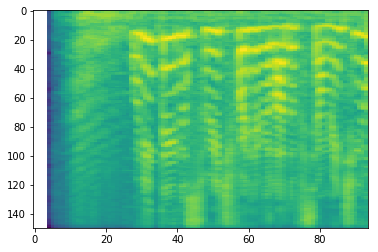

In [25]:
plt.imshow(np.log(signal2_mel),aspect='auto')

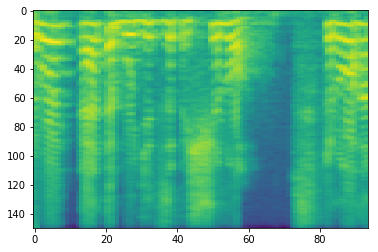

In [26]:
plt.imshow(np.log(signal1_mel),aspect='auto')

In [241]:
sf.write('../mix_audio/mix.wav', s3, samplerate=SR)

RuntimeError: Error opening '../mix_audio/mix.wav': System error.

In [211]:
signal, _ = librosa.load(l, sr=16000)

In [213]:
from IPython.display import Audio
sr = 16000
Audio(signal, rate=sr)

In [215]:
signal2 = librosa.util.normalize(signal, norm=2)

In [217]:
signal2

array([-0.00216162, -0.00550694, -0.00734421, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [216]:
Audio(signal2, rate=sr)

In [212]:
signal

array([-0.02467311, -0.06285726, -0.08382816, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [208]:
l.split('-')[0]

'akwvpAiLFk0'

In [203]:
from ffmpy import FFmpeg

def separate_mp4(video_in_path, video_out_path, wav_out_path):
    ff = FFmpegff = FFmpeg(inputs={video_in_path: None},\
                           outputs={video_out_path: ['-map', '0:0', '-c:a', 'copy', '-f', 'mp4'],\
                                    wav_out_path: ['-map', '0:1', '-c:a', 'copy', '-f', 'mp4']})
    ff.run()
    

In [204]:
def process_and_save(dict_path):
    with open(dict_path, 'r') as f:
        reader = csv.reader(f)
        for row in reader:
            video_in_path = row[0]
            video_out_path = '../separated_data/' + '/video/' + row[2] + '-' + row[3] + '.mp4'
            #video_out_path = row[3] + '.mp4'
            wav_out_path = '../separated_data/' + '/audio/' + row[2]  + '-' + row[3] + '.wav'
            try:
                os.makedirs('../separated_data/' + 'video')
            except FileExistsError:
                pass
            try:
                os.makedirs('../separated_data/' + 'audio')
            except FileExistsError:
                pass
                    
                         
                         
                         
                         
                         
            #wav_out_path = row[3] + '.wav'
            #separate_mp4(video_in_path, video_out_path, wav_out_path)
            
            command = 'ffmpeg -i {0} -map 0:0 -c:a copy -f mp4 {1} -map 0:1 -c:a copy -f mp4 {2}'.format(video_in_path, video_out_path, wav_out_path)
            subprocess.call(command, shell=True)

    

In [205]:
process_and_save('test_dict.csv')

In [129]:
ff = FFmpeg(inputs={video_path: None},outputs={'video.mp4': ['-map', '0:0', '-c:a', 'copy', '-f', 'mp4'],\
                                              'audio.wav': ['-map', '0:1', '-c:a', 'copy', '-f', 'mp4']})

In [130]:
ff.cmd

'ffmpeg -i ../data/test/akwvpAiLFk0_144.680000-150.000000.mp4 -map 0:0 -c:a copy -f mp4 video.mp4 -map 0:1 -c:a copy -f mp4 audio.wav'

In [131]:
ff.run()

(None, None)

In [187]:
os.mkdir('../separated_data1')

In [72]:
import librosa
from IPython.display import Audio
signal, sr = librosa.load('144.680000-150.000000.wav')

In [73]:
sr

22050

In [75]:
signal

array([], dtype=float32)

In [74]:
Audio(signal, rate=sr)

ValueError: zero-size array to reduction operation maximum which has no identity

In [123]:
command = 'ffmpeg -i ./036.033000-040.900000.wav -ab 160k -ac 2 -ar 44100 -vn ../audio_1.wav'

In [142]:
command = 'ffmpeg -i ../data/test/akwvpAiLFk0_144.680000-150.000000.mp4 -map 0:0 -c:a copy -f mp4 ../data/video.mp4 -map 0:1 -c:a copy -f mp4 ../data/audio.wav'
            

In [143]:
import subprocess
subprocess.call(command, shell=True)

0

In [1]:
a = ['144.680000-150.000000', '090.000000-093.566667']

In [2]:
a

['144.680000-150.000000', '090.000000-093.566667']

In [3]:
a.sort()

In [4]:
a

['090.000000-093.566667', '144.680000-150.000000']